# Minimal code for Figure S2e polysome profiling panels

In [1]:
# turn off warnings
options(warn = -1)
suppressPackageStartupMessages({
  library(tidyverse)
  library(rasilabRtemplates)
})

cbPalette_12 <- c(
  "#999999", "#CC6677", "#88CCEE", "#661100", "#117733", "#332288", 
  "#999933","#AA4499", "#44AA99", "#882255", "#6699CC", "#DDCC77"
)

theme_set(theme_rasilab() +
  theme(
    axis.line = element_line(color = "grey"),
    axis.title.y = element_text(margin = margin(r = 10)),
    axis.title.x = element_text(margin = margin(t = 10))
  ))

In [2]:
if (!file.exists('../figures')){
    dir.create('../figures')
}

## Read annotations

In [3]:
annotations <- read_csv("../annotations/sampleannotations.csv", col_types = cols(.default = "c")) %>% 
  print()

# A tibble: 5 × 2
  file                sample 
  <chr>               <chr>  
1 20241104_i287_1.csv sgCNOT1
2 20241104_i287_2.csv sgPSMA4
3 20241104_i287_4.csv sgRPS19
4 20241104_i287_5.csv sgTCP1 
5 20241104_i287_6.csv sgFLUC 


## Read data

In [4]:
counts <- list.files("../../../../data/polysome_profiling/polysome_relic_hits/", pattern = "\\d\\.csv", full.names = T) %>% 
  enframe("sno", "file") %>% 
  mutate(data = map(file, . %>%
                      read_csv(., skip = 45, show_col_types = F) %>%
                      select(`Position(mm)`, Absorbance, `Fraction Number`)
                      ))%>%
  unnest() %>%
  rename(AbsA = Absorbance,
       Fraction = `Fraction Number`,
       Position = `Position(mm)`) %>%
  mutate(file = str_extract(file, "20241104_i287_\\d.csv")) %>%
  left_join(annotations) %>%
  filter(!is.na(sample)) %>%
  select(-sno, -file) %>%  
  print()

Joining, by = "file"


# A tibble: 3,931 × 4
   Position  AbsA Fraction sample 
      <dbl> <dbl> <chr>    <chr>  
 1     0    0.331 NA       sgCNOT1
 2     0.1  0.837 NA       sgCNOT1
 3     0.19 0.287 NA       sgCNOT1
 4     0.29 1.10  NA       sgCNOT1
 5     0.39 0.361 NA       sgCNOT1
 6     0.49 0.962 NA       sgCNOT1
 7     0.59 1.13  NA       sgCNOT1
 8     0.69 0.480 NA       sgCNOT1
 9     0.79 0.519 NA       sgCNOT1
10     0.89 0.502 NA       sgCNOT1
# … with 3,921 more rows


## Standardize traces

In [5]:
standardized <- counts %>%
    # remove all initial values < 0
    filter(!(AbsA < 0 & Position < 10)) %>%
    # make baseline equal to 0
    group_by(sample) %>%
    mutate(AbsA = AbsA - min(AbsA)) %>%
    ungroup()

## Calculate P/M ratio

In [6]:
PbyM <- standardized %>%
    group_by(sample) %>%
    # Pick a minimum position just short of 40S and 60S peaks
    summarize(
      M = sum(AbsA[Position > 10 & Position < 28]),
      P = sum(AbsA[Position >= 28 & Position < 80])
    ) %>% 
    mutate(PbyM = P/M)  %>% 
    mutate(PbyM = PbyM / PbyM[sample == "sgFLUC"])  %>% 
    mutate(PbyM = round(PbyM, 2))  %>% 
    arrange(desc(PbyM))

PbyM

sample,M,P,PbyM
<chr>,<dbl>,<dbl>,<dbl>
sgFLUC,19.41406,21.998010,1.00
sgCNOT1,18.63454,18.442545,0.87
sgTCP1,21.76555,19.463395,0.79
sgRPS19,14.11332,10.375486,0.65
sgPSMA4,17.87372,7.642281,0.38


## Normalize to approximate value of 80S

In [7]:
normalized_counts <- standardized %>%
    group_by(sample) %>%
    mutate(AbsA = AbsA - min(AbsA)) %>%
    mutate(MonoAbsA = max(AbsA[Position > 10])) %>%
    mutate(AbsA = AbsA/MonoAbsA)

## Plot normalized absorbance

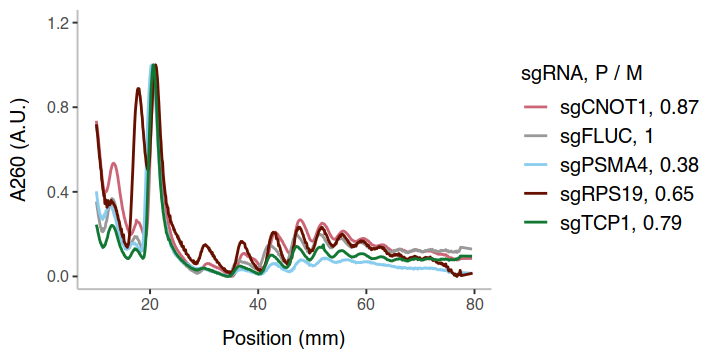

In [10]:
options(repr.plot.width=6, repr.plot.height=3)

# put them all on one plot
normalized_counts %>%
  filter(Position > 10 & Position < 80, ! sample %in% c("sgRPL5")) %>% 
  left_join(PbyM, by = "sample") %>%
  mutate(sample = paste0(sample, ", ", PbyM)) %>%
  write_csv("../../../../source_data/figure_s2e.csv") %>%
  ggplot(aes(x = Position, y = AbsA, color = sample)) +
  geom_line(linewidth = 0.8) +
  xlab("Position (mm)") +
  ylab("A260 (A.U.)") +
  labs(color = "sgRNA, P / M") +
  scale_y_continuous(limits = c(0, 1.2), breaks = c(0, 0.4, 0.8, 1.2)) +
  scale_color_manual(values = cbPalette_12[c(2,1,3,4,5)])

ggsave("../figures/normalized_trace_with_PbyM.pdf", width = 6, height = 3, units = "in")